In [2]:
from music21 import converter, note, chord, harmony, meter, stream
import numpy as np
from data_utils import extract_lead_sheet_info

/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
root_dir = '/media/maindisk/maximos/data/hooktheory_train/'

for dirpath, _, filenames in os.walk(root_dir):
    for file in filenames:
        if file.endswith('.xml') or file.endswith('.mxl') or file.endswith('.musicxml'):
            full_path = os.path.join(dirpath, file)
            break
print(full_path)

pianoroll, chord_seq = extract_lead_sheet_info(full_path, fixed_length=256)

print("Pianoroll shape:", pianoroll.shape)  # (256, 100) -> 12 pitch class + 88 piano roll
print("Chord seq length:", len(chord_seq))  # Should match T
print("Chord at step 0:", chord_seq[0])


/media/maindisk/maximos/data/hooktheory_train/h/haim/dont-save-me/chorus.xml
Pianoroll shape: (256, 100)
Chord seq length: 256
Chord at step 0: Em


/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


In [4]:
print(len(chord_seq))
print(chord_seq)

256
['Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am

In [5]:
from GridMLM_tokenizers import CSGridMLMTokenizer

In [6]:
tokenizer = CSGridMLMTokenizer(fixed_length=256)

In [7]:
x = tokenizer.encode(full_path)

In [8]:
print(x['input_ids'])
print(x['input_tokens'])
print(x['pianoroll'].shape)
print(len(x['attention_mask']))
print(x['time_signature'])

[123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [9]:
from models import GridMLMMelHarm

In [10]:
model = GridMLMMelHarm(chord_vocab_size=len(tokenizer.vocab), conditioning_dim=16)

In [11]:
from data_utils import CSGridMLMDataset, CSGridMLM_collate_fn
from torch.utils.data import DataLoader

In [12]:
train_dir = '/media/maindisk/maximos/data/hooktheory_train'
train_dataset = CSGridMLMDataset(train_dir, tokenizer, 512)

In [13]:
x = train_dataset[0]
print(x['input_ids'])

[6, 6, 6, 6, 6, 6, 6, 6, 11, 11, 11, 11, 11, 11, 11, 11, 151, 151, 151, 151, 151, 151, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 6, 6, 6, 6, 6, 6, 6, 6, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 6, 6, 6, 6, 6, 6, 6, 6, 11, 11, 11, 11, 11, 11, 11, 11, 151, 151, 151, 151, 151, 151, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 296, 296, 296, 296, 296, 296, 296, 151, 151, 151, 151, 151, 151, 151, 151, 151, 6, 6, 6, 6, 6, 6, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 6, 6, 6, 6, 6, 6, 6, 6, 11, 11, 11, 11, 11, 11, 11, 11, 151, 151, 151, 151, 151, 151, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 6, 6, 6, 6, 6, 6, 6, 6, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 6, 6, 6, 6, 6, 6, 6, 6, 11, 11, 11, 11, 11, 11, 11, 11, 151, 151, 151, 151, 151, 151, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 296, 296, 296, 296, 296, 296, 296, 151, 151, 151, 151, 151, 151, 151, 151, 151, 6, 6, 6

/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


In [14]:
trainloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=CSGridMLM_collate_fn)

In [15]:
batch = next(iter(trainloader))

In [16]:
print(batch['input_ids'].shape)
print(batch['pianoroll'].shape)

torch.Size([8, 256])
torch.Size([8, 256, 100])


In [17]:
y = model( batch['time_signature'].to(model.device), batch['pianoroll'].to(model.device) )

In [18]:
print(y.shape)

torch.Size([8, 256, 354])


In [19]:
from train_utils import apply_structured_masking, train_with_curriculum

In [20]:
import matplotlib.pyplot as plt
from train_utils import apply_structured_masking

([], [])

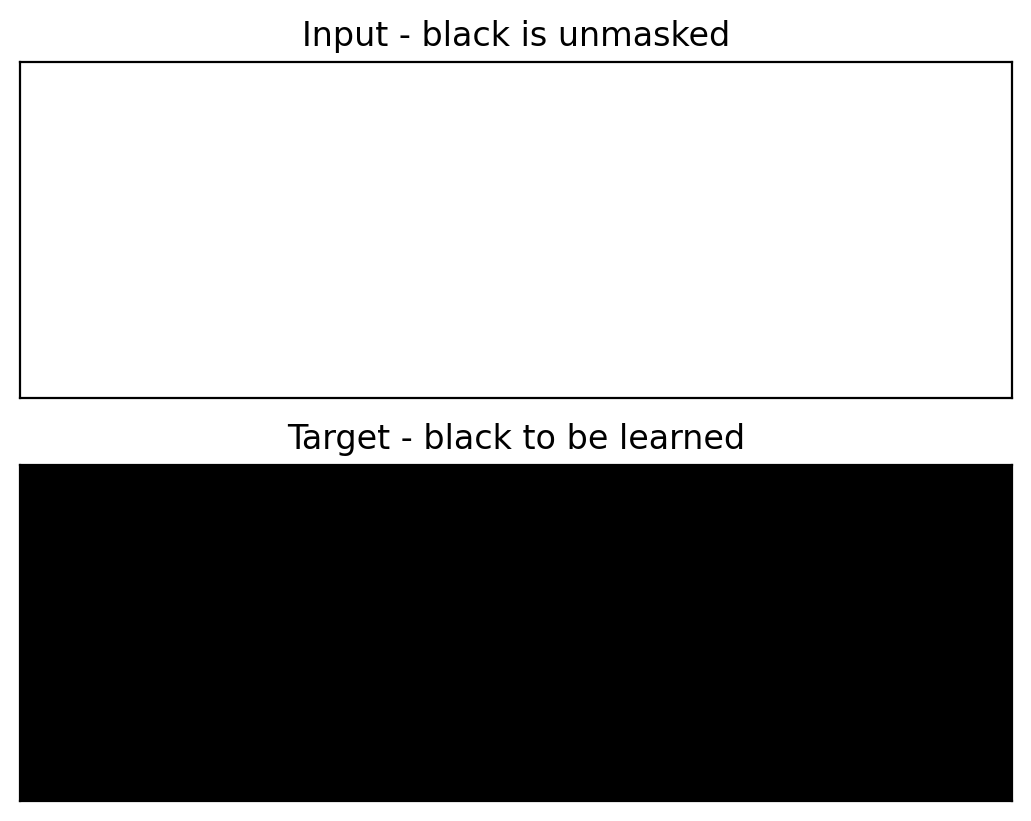

In [21]:
mask_token_id = tokenizer.mask_token_id  # <mask> token index
step_idx = 0

masked_harmony, target = apply_structured_masking(
    batch['input_ids'],
    mask_token_id,
    step_idx,
    batch['time_signature'],
    curriculum_type='no' # 'no', 'random', 'ts_blank', 'ts_incr'
)
# print(masked_harmony)
# print(target)
plt.subplot(2,1,1)
plt.imshow(masked_harmony!=mask_token_id, aspect='auto', cmap='gray_r', vmin=0, vmax=1)
plt.title('Input - black is unmasked')
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.imshow(target>-100, aspect='auto', cmap='gray_r', vmin=0, vmax=1)
plt.title('Target - black to be learned')
plt.xticks([])
plt.yticks([])

([], [])

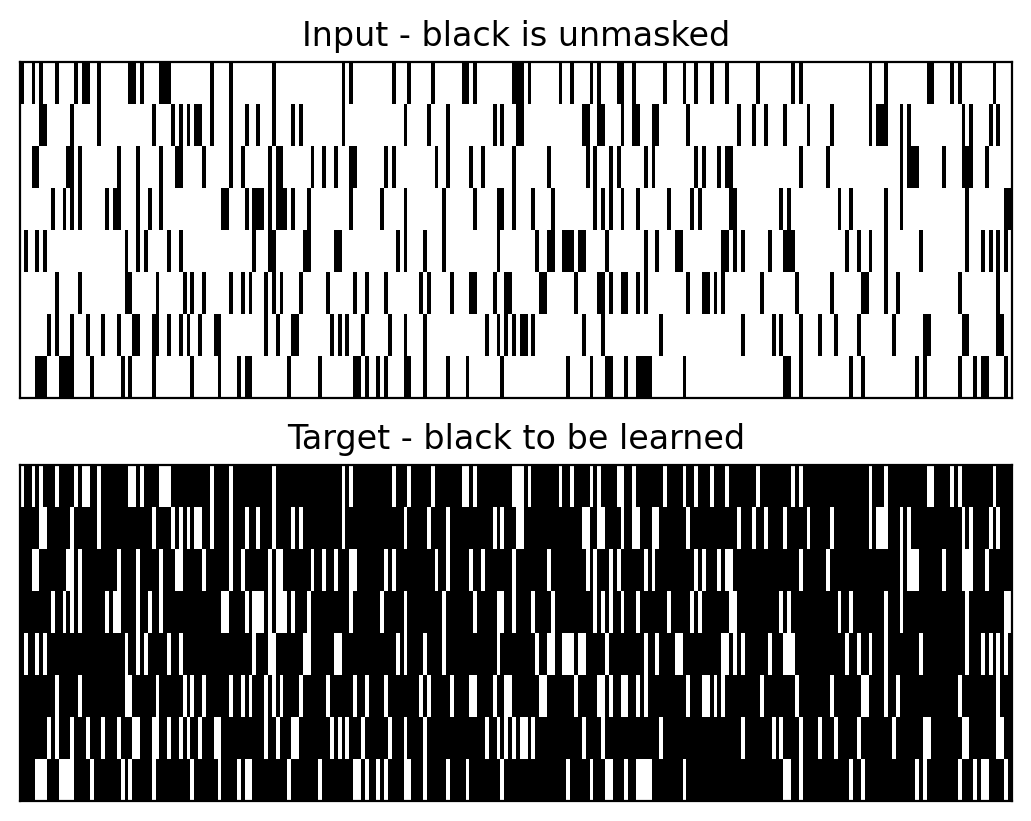

In [22]:
step_idx = 3
masked_harmony, target = apply_structured_masking(
    batch['input_ids'],
    mask_token_id,
    step_idx,
    batch['time_signature'],
    curriculum_type='random' # 'no', 'random', 'ts_blank', 'ts_incr'
)
# print(masked_harmony)
# print(target)
plt.subplot(2,1,1)
plt.imshow(masked_harmony!=mask_token_id, aspect='auto', cmap='gray_r', vmin=0, vmax=1)
plt.title('Input - black is unmasked')
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.imshow(target>-100, aspect='auto', cmap='gray_r', vmin=0, vmax=1)
plt.title('Target - black to be learned')
plt.xticks([])
plt.yticks([])

([], [])

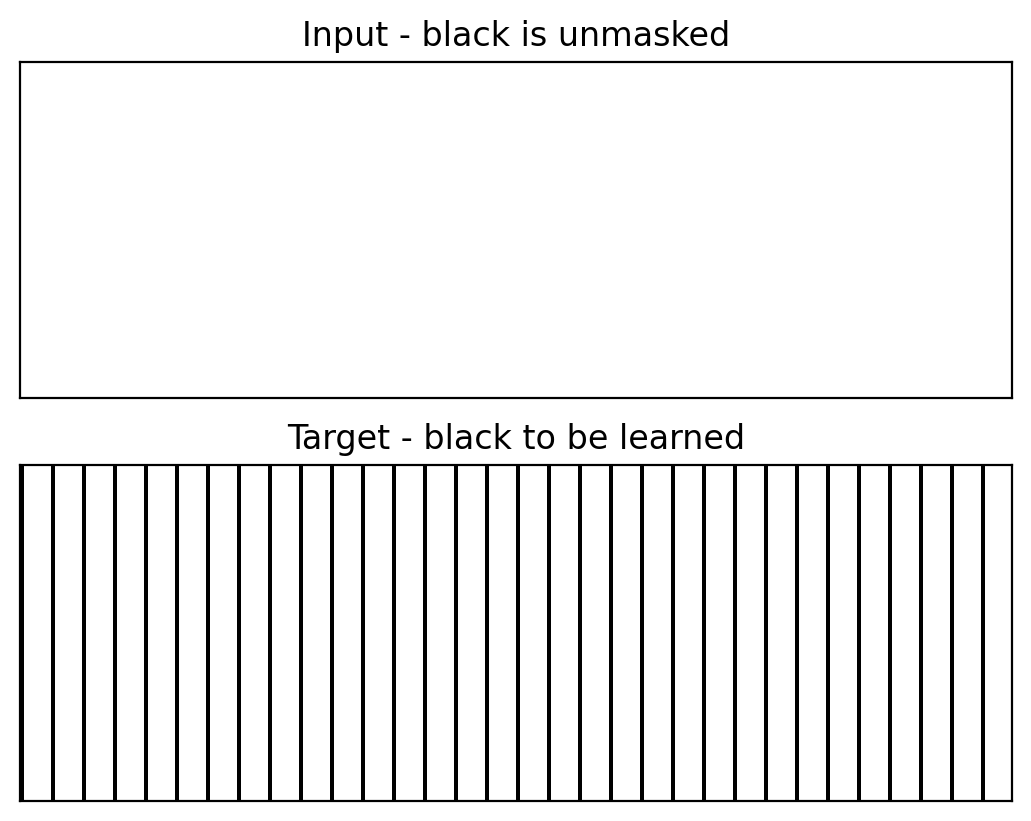

In [23]:
step_idx = 3
masked_harmony, target = apply_structured_masking(
    batch['input_ids'],
    mask_token_id,
    step_idx,
    batch['time_signature'],
    curriculum_type='ts_blank' # 'no', 'random', 'ts_blank', 'ts_incr'
)
# print(masked_harmony)
# print(target)
plt.subplot(2,1,1)
plt.imshow(masked_harmony!=mask_token_id, aspect='auto', cmap='gray_r', vmin=0, vmax=1)
plt.title('Input - black is unmasked')
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.imshow(target>-100, aspect='auto', cmap='gray_r', vmin=0, vmax=1)
plt.title('Target - black to be learned')
plt.xticks([])
plt.yticks([])

([], [])

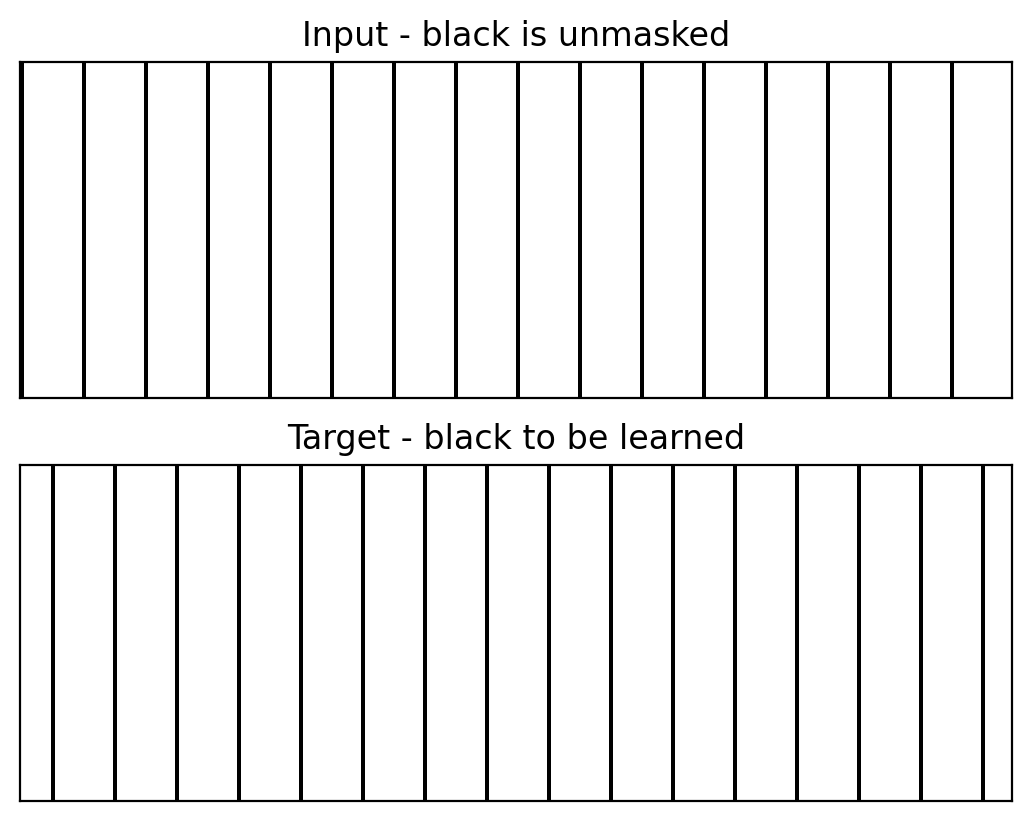

In [24]:
step_idx = 3
masked_harmony, target = apply_structured_masking(
    batch['input_ids'],
    mask_token_id,
    step_idx,
    batch['time_signature'],
    curriculum_type='ts_incr' # 'no', 'random', 'ts_blank', 'ts_incr'
)
# print(masked_harmony)
# print(target)
plt.subplot(2,1,1)
plt.imshow(masked_harmony!=mask_token_id, aspect='auto', cmap='gray_r', vmin=0, vmax=1)
plt.title('Input - black is unmasked')
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.imshow(target>-100, aspect='auto', cmap='gray_r', vmin=0, vmax=1)
plt.title('Target - black to be learned')
plt.xticks([])
plt.yticks([])

In [25]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
mask_token_id = tokenizer.mask_token_id  # <mask> token index

lr = 0.00005
optimizer = AdamW(model.parameters(), lr=lr)

train_with_curriculum(
    model=model,
    optimizer=optimizer,
    trainloader=trainloader,
    loss_fn=CrossEntropyLoss(ignore_index=-100),
    mask_token_id=mask_token_id,
    epochs=20,
    curriculum_type='no',  # or "linear"
    epochs_per_stage=3        # only for linear
)


Epoch 0 (step 0) | trn:   0%|          | 0/1710 [00:00<?, ?batch/s]/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
Epoch 0 (step 0) | trn:   4%|▍         | 76/1710 [00:19<06:52,  3.96batch/s, accuracy=0.337, loss=3.07]


KeyboardInterrupt: 